###### SLICENET QoE  from QoS Estimator

## Overview:
The objective of this PoC is to demonstrate the ability to estimate QoE, as perceived by the user, by applying cognitive methods to analyse network-level metrics collected by the service provider. The assumption is that the service provider can measure various QoS metrics; however, does not have full information on the actual QoE that the user is experiencing. Therefore, it must estimate the QoE from the measured QoS metrics. We employ ML to learn the QoS relationship to QoE through training with labelled examples. The learned data can be utilized at run-time to predict probable SLA violations and trigger corrective measures. 

This approach is intended to be integrated into the SliceNet eHealth UC and exercises several SliceNet workflows; including, E2E service cognition, monitoring, and QoE feedback. The PoC is focused on the QoE KPI of E2E latency.
Following the SliceNet data-driven operations approach, the model is deployed as part of the slice to generate an Estimated-QoE metric from monitored QoS KPIs. This metric is then consumed by slice control functions to trigger control and/or management actions required for proactively maintaining the service-level QoE, before any degradation affects the user.

## Scenario
The scenario for this PoC includes the following steps:
1. Measuring QoE – in order to develop our approach, we created a controlled environment, where we can measure both network QoS parameters and application-level QoE, e.g.workload duration. We use a web service (WordPress) and measure the service level from the client perspective. The QoE is defined as a threshold on the average download time of the desired WordPress content. The application is created on two Kubernetes (K8s) container clouds deployed through the IBM ICP service; the client is on one cluster and the application on the other. The QoE was measured using JMeter.
2. Generating different quality of experiences – we generate “other” network traffic on both clusters using a stresser application that we have implemented. The stresser creates multiple containers and generates controlled traffic between them using iperf.
3. Measuring QoS – under our simulation model assumptions, the slice service provider can only measure local metrics within its slice. In our environment, we limited the QoS measurements to the K8s cluster that runs the WordPress service; namely, there are no metrics from the client cluster. The measurements are performed through SkyDive flow capturing.
4. Training Set – QoS metrics from each experiment iteration are matched against the QoE measurement by time (wall-clock). For each iteration, we collect measurements only in the middle of the experiment window to remove the effect of end conditions (such as noise associated with creating the stresser containers). A validation set is created in a similar way.
5. Learning – We apply classification ML to infer the measured QoE class from the collected SkyDive metrics.
6. Model Validation – The model is validated against the validation set.

## PoC experiment setup and Implementation details:

The PoC experiment setup is described in the Figure at https://drive.google.com/file/d/142FpFA_BjYh2hIZU3qlv67ibOoEdbxKe/view. K8s Cluster 2 corresponds to a managed slice, where the slice provider collects QoS metrics (through SkyDive) in order to manage the slice QoE. Stresser nodes generate controlled traffic to vary the E2E service behaviour; namely the QoE of the client. Actual service-level E2E QoE metrics are collected (by JMeter) and provided by the vertical (service user) for model training and validation. A ML classification process learns a QoE sensor model that estimates E2E QoE from measured QoS metrics. The model is then validated.

In order to simulate the user’s workload, an application to generate WordPress client traffic to our WordPress service has been implemented. A test driver was designed to coordinate the running of the WordPress client workloads concurrently with various levels of stress generated by iperf3 https://github.com/esnet/iperf. The test driver also maintained an index that recorded the start time, end time, workload duration of each experimental sample used to pair the data-bases maintained by Skydive and Jmeter. The WordPress client workloads consisted of multiple concurrent downloads of the two files, 5MB and 15MB, from WordPress Server. The downloads were done with HTTP Keep-Alive set to false. In the background the network stresser ran various levels of stress including no stress.
Skydive collected network flow metrics (QoS) and stored it in an ElasticSearch DB. We directed Skydive to capture network flow metrics on the WordPress service interface, i.e. eth0. Likewise, Jmeter collected performance date related to the client application and stored it in an influxDB. Skydive’s ElasticSearch DB, Jmeter’s influxDB, and the Test Driver’s Index were copied to an IBM Cloud Object Store (COS).
Analysis of the data was done in an IBM Watson Studio notebook with a Python 3.5 kernel. The Python Data Analysis Library (Pandas) was used to aggregate the QoS and QoE measures. Finally, the Python Scikit-learn library was used for creating the ML models. 

## Estimate Workload Duration (QoE) from measured QoS features.
The PoC's ML evaluation properties are outlined below:
* Establish threshold boundaries to be used in the classification by examining the QoE measurments  
* Evaluate for both Binary Classification and Multiclass Classification
* Evaluate with all of the ML classifiers
* Evaluate with all of combinations of QoS Features
* Compare the evaluation methods (classifier and feature combination) and determine the best performers


## Target QoE
The target QoE used in the evaluation was the workload duration recorded by the test driver. 


## QoS Features
The following QoS features were used in the evaluation:
*       flow_duration_mean
*       bytes_per_flow_mean
*       packets_per_flow_mean
*       AB_bytes_per_flow_mean
*       BA_bytes_per_flow_mean
*       AB_packets_per_flow_mean
*       BA_packets_per_flow_mean
*       RTT_mean

All combinations of the above features were exercised to determine which could be used by the classifiers described below to best predict the target QoE.
All of the features were derived from network metrics collected by skydive. Flow duration was derived from the difference between Skydive’s Metric.Last and Metric.Start.  

## Classifiers
Different scikit classifiers were used in the analysis.  The classifiers were compared to determine which best predicted the target QoE using QoS features described above.  
The following classifiers were used in the evaluation:
* LogisticRegression
* DecisionTreeClassifier
* KNeighborsClassifier             
* LinearDiscriminantAnalysis
* RandomForestClassifier
* GaussianNB
* SVC
* MLPClassifier  (removed because it was taking too long)
* GaussianProcessClassifier(removed because it was taking too long) 
* AdaBoostClassifier
* QuadraticDiscriminantAnalysis

## Conclusion
The LogicalRegression Classifier is the best classifier for both Binary Classification and MultiClass Classification.
The table below summarizes the results:

* training set 616
* testing set 203


| Classification | Classifier             | features           |  f1_score | accuracy_score | log_loss_score |
| -------------  |:----------------------:|:------------------:|:----------:|---------------:| ---------------:|
| binary         | LinearDiscriminantAnalysis | packets_per_flow_mean<br>AB_bytes_per_flow_mean<br>BA_bytes_per_flow_mean<br>BA_packets_per_flow_mean<br>RTT_mean | .921        |.921             | .199 |
| multiclass     | QuadraticDiscriminantAnalysis | flow_duration_mean<br>bytes_per_flow_mean<br>packets_per_flow_mean<br>AB_bytes_per_flow_mean<br>BA_bytes_per_flow_mean<br>BA_packets_per_flow_mean | .833        |.833             | .415 |



In [208]:
#!pip install cufflinks==0.8.2 --user
#!pip install mlxtend

In [138]:
import pandas as pd
import numpy as np
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import plotly.figure_factory as ff
#import cufflinks as cf
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=ResourceWarning)


In [139]:
from sklearn.model_selection        import train_test_split
from sklearn                        import metrics, svm
from sklearn.linear_model           import LinearRegression
from sklearn.linear_model           import LogisticRegression
from sklearn.tree                   import DecisionTreeClassifier
from sklearn.neighbors              import KNeighborsClassifier
from sklearn.discriminant_analysis  import LinearDiscriminantAnalysis
from sklearn.naive_bayes            import GaussianNB
from sklearn.svm                    import SVC
#from sklearn.linear_model           import Ridge
#from sklearn.linear_model           import Lasso
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neural_network         import MLPClassifier
from sklearn.ensemble               import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics                import f1_score
from sklearn.metrics                import accuracy_score
from sklearn.metrics                import precision_score
from sklearn.metrics                import recall_score
from sklearn.metrics import roc_auc_score, log_loss


In [140]:
init_notebook_mode(connected=True)

In [141]:
# The code was removed by Watson Studio for sharing.

In [142]:
def plotJmeter(df,title):
    traces=[]
    for transaction in df['transaction'].unique():
        trace = go.Scatter(
            y=df[df['transaction']==transaction]['avg'],
            x=df[df['transaction']==transaction]['time'],
            mode = 'markers',
            connectgaps=True,
            name=transaction
        )    
        traces.append(trace)
  
       
    layout = go.Layout(
            barmode='group',
            title=title,
            xaxis=dict(
                title="time",
                #tickvals=xtickvals
            ),
            yaxis=dict(
                title="Response Time (ms)"
            )
    )

    fig = go.Figure(data=traces, layout=layout)
    iplot(fig)    

In [143]:
def plotJmeter2(df1,df2,title):
    traces=[]
    for transaction in df1['transaction'].unique():
        trace = go.Scatter(
            y=df1[df1['transaction']==transaction]['avg'],
            x=df1[df1['transaction']==transaction]['time'],
            mode = 'markers',
            connectgaps=True,
            name=transaction+" "+"with no background stress"
        )    
        traces.append(trace)
    for transaction in df2['transaction'].unique():
        trace = go.Scatter(
            y=df2[df2['transaction']==transaction]['avg'],
            x=df2[df2['transaction']==transaction]['time'],
            mode = 'markers',
            connectgaps=True,
            name=transaction+" "+"with background stress"
        )    
        traces.append(trace)        
  
       
    layout = go.Layout(
            barmode='group',
            title=title,
            xaxis=dict(
                title="time",
                #tickvals=xtickvals
            ),
            yaxis=dict(
                title="Response Time (ms)"
            )
    )

    fig = go.Figure(data=traces, layout=layout)
    iplot(fig)    

In [144]:
def plotSkydiveFlows2(df1,df2,title,y_feature,y_title):
    traces=[]
    for name in df1['_source.NodeTID'].unique():
        trace = go.Scatter(
            y=df1[df1['_source.NodeTID']==name][y_feature],
            x=df1[df1['_source.NodeTID']==name]['_source.Metric.Last'],
            mode = 'markers',
            #connectgaps=True,
            name=name+" with no background stress"
        )    
        traces.append(trace)
    for name in df2['_source.NodeTID'].unique():
        trace = go.Scatter(
            y=df2[df2['_source.NodeTID']==name][y_feature],
            x=df2[df2['_source.NodeTID']==name]['_source.Metric.Last'],
            mode = 'markers',
            #connectgaps=True,
            name=name+" with background stress"
        )    
        traces.append(trace)           
       
    layout = go.Layout(
            barmode='group',
            title=title,
            xaxis=dict(
                title="time",
                #tickvals=xtickvals
            ),
            yaxis=dict(
                title=y_title
            )
    )

    fig = go.Figure(data=traces, layout=layout)
    iplot(fig)    

In [145]:
def plotSkydiveFlows(df,title,y_feature,y_title):
    traces=[]
    for name in df['_source.NodeTID'].unique():
        trace = go.Scatter(
            y=df[df['_source.NodeTID']==name][y_feature],
            x=df[df['_source.NodeTID']==name]['_source.Metric.Last'],
            mode = 'markers',
            #connectgaps=True,
            name=name
        )    
        traces.append(trace)        
       
    layout = go.Layout(
            barmode='group',
            title=title,
            xaxis=dict(
                title="time",
            ),
            yaxis=dict(
                title=y_title
            )
    )

    fig = go.Figure(data=traces, layout=layout)
    iplot(fig)    

In [146]:
def plot4(df1,df2,df3,df4,title):
    traces=[]
    for transaction in df1['transaction'].unique():
        trace = go.Scatter(
            y=df1[df1['transaction']==transaction]['avg'],
            x=df1[df1['transaction']==transaction]['time'],
            mode = 'markers',
            connectgaps=True,
            name=transaction+" "+"with no background stress",
            text = ["with no background stress"],
            textposition='top right'
        )    
        traces.append(trace)
    for transaction in df2['transaction'].unique():
        trace = go.Scatter(
            y=df2[df2['transaction']==transaction]['avg'],
            x=df2[df2['transaction']==transaction]['time'],
            mode = 'markers',
            connectgaps=True,
            name=transaction+" "+"with background stress"
        )    
        traces.append(trace)
    for name in df3['_source.NodeTID'].unique():
        trace = go.Scatter(
            y=df3[df3['_source.NodeTID']==name]['_source.Metric.RTT'],
            x=df3[df3['_source.NodeTID']==name]['_source.Metric.Last'],
            mode = 'markers',
            connectgaps=True,
            name=name+" with no background stress",
            xaxis='x2',
            yaxis='y2'
        )    
        traces.append(trace)
    for name in df4['_source.NodeTID'].unique():
        trace = go.Scatter(
            y=df4[df4['_source.NodeTID']==name]['_source.Metric.RTT'],
            x=df4[df4['_source.NodeTID']==name]['_source.Metric.Last'],
            mode = 'markers',
            connectgaps=True,
            name=name+" with background stress",
            xaxis='x2',
            yaxis='y2'            
        )    
        traces.append(trace)             
  
       
    layout = go.Layout(
            barmode='group',
            title=title,
            xaxis=dict(
                title="time",
                #tickvals=xtickvals
            ),
            yaxis=dict(
                title="ms"
            )
    )
    layout = go.Layout(
        title=title,
        xaxis=dict(
                       
            domain=[0, 1]
        ),
        yaxis=dict(
            title="response time (QoE)",
            domain=[0.55, 1]
            
        ),
        xaxis2=dict(
            #title="time",
            domain=[0, 1],
            anchor='y2'
        ),


        yaxis2=dict(
            title="RTT (QoE)",
            domain=[0, 0.45]
            
        ),
        showlegend=False,
        annotations = [
            dict(
                  #x = -0.0951769406393,
                  x = 0.0951769406393,
                  #y = 0.96972670892,
                  y = 1,
                  showarrow = False,
                  text = "Without Stress",
                  xref = "paper",
                  yref = "paper"
            ),
            dict(
                  #x = -0.0951769406393,
                  #x = 0.2951769406393,
                  x = 0.8,
                  #y = 0.96972670892,
                  y = 1,
                  showarrow = False,
                  text = "With Stress",
                  xref = "paper",
                  yref = "paper"
            ),
            dict(
                  #x = -0.0951769406393,
                  x = 0.0951769406393,
                  y = 0.36972670892,
                  showarrow = False,
                  text = "Without Stress",
                  xref = "paper",
                  yref = "paper"
            ),
            dict(
                  #x = -0.0951769406393,
                  x = 0.8,
                  y = 0.36972670892,
                  showarrow = False,
                  text = "With Stress",
                  xref = "paper",
                  yref = "paper"
            )            
            
        ]

    )

    fig = go.Figure(data=traces, layout=layout)
    iplot(fig)    

In [147]:
def plotQoEQoS(df1,df2,df3,df4,y_feature,y_title1,y_title2,title):
    traces=[]
    for transaction in df1['transaction'].unique():
        trace = go.Scatter(
            y=df1[df1['transaction']==transaction]['avg'],
            x=df1[df1['transaction']==transaction]['time'],
            mode = 'markers',
            connectgaps=True,
            name=transaction+" "+"with no background stress",
            text = ["with no background stress"],
            textposition='top right'
        )    
        traces.append(trace)
    for transaction in df2['transaction'].unique():
        trace = go.Scatter(
            y=df2[df2['transaction']==transaction]['avg'],
            x=df2[df2['transaction']==transaction]['time'],
            mode = 'markers',
            connectgaps=True,
            name=transaction+" "+"with background stress"
        )    
        traces.append(trace)
    for name in df3['_source.NodeTID'].unique():
        trace = go.Scatter(
            y=df3[df3['_source.NodeTID']==name][y_feature],
            x=df3[df3['_source.NodeTID']==name]['_source.Metric.Last'],
            mode = 'markers',
            connectgaps=True,
            name=name+" with no background stress",
            xaxis='x2',
            yaxis='y2'
        )    
        traces.append(trace)
    for name in df4['_source.NodeTID'].unique():
        trace = go.Scatter(
            y=df4[df4['_source.NodeTID']==name][y_feature],
            x=df4[df4['_source.NodeTID']==name]['_source.Metric.Last'],
            mode = 'markers',
            connectgaps=True,
            name=name+" with background stress",
            xaxis='x2',
            yaxis='y2'            
        )    
        traces.append(trace)             
  
       
    layout = go.Layout(
            barmode='group',
            title=title,
            xaxis=dict(
                title="time",
                #tickvals=xtickvals
            ),
            yaxis=dict(
                title="ms"
            )
    )
    layout = go.Layout(
        title=title,
        xaxis=dict(
                       
            domain=[0, 1]
        ),
        yaxis=dict(
            title=y_title1,
            domain=[0.55, 1]
            
        ),
        xaxis2=dict(
            #title="time",
            domain=[0, 1],
            anchor='y2'
        ),


        yaxis2=dict(
            title=y_title2,
            domain=[0, 0.45]
            
        ),
        showlegend=False,
        annotations = [
            dict(
                  #x = -0.0951769406393,
                  x = 0.0951769406393,
                  #y = 0.96972670892,
                  y = 1,
                  showarrow = False,
                  text = "Without Stress",
                  xref = "paper",
                  yref = "paper"
            ),
            dict(
                  #x = -0.0951769406393,
                  #x = 0.2951769406393,
                  x = 0.8,
                  #y = 0.96972670892,
                  y = 1,
                  showarrow = False,
                  text = "With Stress",
                  xref = "paper",
                  yref = "paper"
            ),
            dict(
                  #x = -0.0951769406393,
                  x = 0.0951769406393,
                  y = 0.36972670892,
                  showarrow = False,
                  text = "Without Stress",
                  xref = "paper",
                  yref = "paper"
            ),
            dict(
                  #x = -0.0951769406393,
                  x = 0.8,
                  y = 0.36972670892,
                  showarrow = False,
                  text = "With Stress",
                  xref = "paper",
                  yref = "paper"
            )            
            
        ]

    )

    fig = go.Figure(data=traces, layout=layout)
    iplot(fig)    

In [148]:
def plot6(df1,df2,df3,df4,df5,df6,title):
    traces=[]
    for transaction in df1['transaction'].unique():
        trace = go.Scatter(
            y=df1[df1['transaction']==transaction]['avg'],
            x=df1[df1['transaction']==transaction]['time'],
            mode = 'markers',
            connectgaps=True,
            name=transaction+" "+"with no background stress",
            text = ["with no background stress"],
            textposition='top right'
        )    
        traces.append(trace)
    for transaction in df2['transaction'].unique():
        trace = go.Scatter(
            y=df2[df2['transaction']==transaction]['avg'],
            x=df2[df2['transaction']==transaction]['time'],
            mode = 'markers',
            connectgaps=True,
            name=transaction+" "+"with background stress"
        )    
        traces.append(trace)
    for name in df3['_source.NodeTID'].unique():
        trace = go.Scatter(
            y=df3[df3['_source.NodeTID']==name]['_source.Metric.RTT'],
            x=df3[df3['_source.NodeTID']==name]['_source.Metric.Last'],
            mode = 'markers',
            connectgaps=True,
            name=name+" with no background stress",
            xaxis='x2',
            yaxis='y2'
        )    
        traces.append(trace)
    for name in df4['_source.NodeTID'].unique():
        trace = go.Scatter(
            y=df4[df4['_source.NodeTID']==name]['_source.Metric.RTT'],
            x=df4[df4['_source.NodeTID']==name]['_source.Metric.Last'],
            mode = 'markers',
            connectgaps=True,
            name=name+" with background stress",
            xaxis='x2',
            yaxis='y2'            
        )    
        traces.append(trace)
    for name in df5['_source.NodeTID'].unique():
        trace = go.Scatter(
            y=df5[df5['_source.NodeTID']==name]['time_to_FIN'],
            x=df5[df5['_source.NodeTID']==name]['_source.Metric.Last'],
            mode = 'markers',
            connectgaps=True,
            name=name+" with no background stress",
            xaxis='x3',
            yaxis='y3'
        )    
        traces.append(trace)
    for name in df6['_source.NodeTID'].unique():
        trace = go.Scatter(
            y=df6[df6['_source.NodeTID']==name]['time_to_FIN'],
            x=df6[df6['_source.NodeTID']==name]['_source.Metric.Last'],
            mode = 'markers',
            connectgaps=True,
            name=name+" with background stress",
            xaxis='x3',
            yaxis='y3'            
        )    
        traces.append(trace)            
  
       
    layout = go.Layout(
            barmode='group',
            title=title,
            xaxis=dict(
                title="time",
                #tickvals=xtickvals
            ),
            yaxis=dict(
                title="ms"
            )
    )
    layout = go.Layout(
        title=title,
        xaxis=dict(                       
            domain=[0, 1],
            anchor='y2'
        ),
        yaxis=dict(
            title="response time (QoE)",
            domain=[0, 0]
            
        ),
        xaxis2=dict(
            #title="time",
            domain=[0.55, 1],
            anchor='y2'
            
        ),
        yaxis2=dict(
            title="RTT (QoE)",
            domain=[0, 0.45]
            
        ),
        xaxis3=dict(
            #title="time",
            domain=[0.55, 1],
            anchor='y3'
        ),
        yaxis3=dict(
            title="Time to FIN (QoE)",
            domain=[0, 1]
            
        ),        
        showlegend=False,
        annotations = [
            dict(
                  #x = -0.0951769406393,
                  x = 0.0951769406393,
                  #y = 0.96972670892,
                  y = 1,
                  showarrow = False,
                  text = "Without Stress",
                  xref = "paper",
                  yref = "paper"
            ),
            dict(
                  #x = -0.0951769406393,
                  #x = 0.2951769406393,
                  x = 0.8,
                  #y = 0.96972670892,
                  y = 1,
                  showarrow = False,
                  text = "With Stress",
                  xref = "paper",
                  yref = "paper"
            ),
            dict(
                  #x = -0.0951769406393,
                  x = 0.0951769406393,
                  y = 0.36972670892,
                  showarrow = False,
                  text = "Without Stress",
                  xref = "paper",
                  yref = "paper"
            ),
            dict(
                  #x = -0.0951769406393,
                  x = 0.8,
                  y = 0.36972670892,
                  showarrow = False,
                  text = "With Stress",
                  xref = "paper",
                  yref = "paper"
            )            
            
        ]

    )

    fig = go.Figure(data=traces, layout=layout)
    iplot(fig)    

In [149]:
#deprecated
def _plotModelEstimates(actual,prediction,xTitle,yTitle,title,names):
    #s = list(map(str,df['begin']))
    #print(s)
    xList = list(range(len(actual)))
    actualBar = go.Scatter(
        y=actual,
        #x=df[xFeature].astype(str),
        x = xList,
        mode = 'markers',
        connectgaps=False,      
        name='actual'
        #text=actual,
        #textposition="outside",
        #textfont=dict(size=18),
        #marker=dict(line=dict(width=1.5)),
        #opacity=5,
        #width=10,
        #orientation='vertical'
    )
    predictionBar = go.Scatter(
        y=prediction,
        #x=df[xFeature].astype(str),
        x = xList,
        mode = 'markers',
        connectgaps=False,        
        name='prediction'
        #text=prediction,
        #textposition="outside",
        #textfont=dict(size=18),
        #marker=dict(line=dict(width=1.5)),
        #opacity=5,
        #width=10,
        #orientation='vertical'
    )
  
    
    data = [actualBar,predictionBar]
    if(len(names)>2):
        shapes=[
                        {
                            'type': 'line',                        
                            'x0': -1,
                            'y0': names[0], # use absolute value or variable here
                            'x1': len(xList),
                            'y1': names[0], 
                            'line': {
                                'color': 'rgb(50, 171, 96)',
                                'width': 4,
                                'dash': 'dashdot',
                            },
                        },                                        {
                            'type': 'line',                        
                            'x0': -1,
                            'y0': names[1], # use absolute value or variable here
                            'x1': len(xList),
                            'y1': names[1], # ditto
                            'line': {
                                'color': 'rgb(255,0,0)',
                                'width': 4,
                                'dash': 'dashdot',
                            },
                        },
                    ]
       
    else:
        shapes=[
                        {
                            'type': 'line',                        
                            'x0': -1,
                            'y0': names[0], # use absolute value or variable here
                            'x1': len(xList),
                            'y1': names[0], # ditto
                            'line': {
                                'color': 'rgb(255,0,0)',
                                'width': 4,
                                'dash': 'dashdot',
                            }
                        }
                    ]
    
    layout = go.Layout(
            barmode='group',
            title=title,
            xaxis=dict(
                title=xTitle,
                #tickvals=df[xFeature].astype(str),
                tickvals=xList                
            ),
            yaxis=dict(
                title=yTitle,
                tickformat=',d'
            ),
            shapes=shapes
    )

    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

In [196]:
def plotWithBoundaries(df,yFeature,xTitle,yTitle,title,low,high):
    #s = list(map(str,df['begin']))
    #print(s)
    #xList = list(range(len(df['begin'])))
    xList = list(range(len(df[yFeature])))
    #xList = list(df[xFeature].unique())
    trace = go.Bar(
        y=df[yFeature],
        #x=df[xFeature].astype(str),
        x=xList,
        name='sample'
        #text=df[yFeature]['min'],
        #textposition="outside",
        #opacity=5,
        #width=3,
        #orientation='vertical'
    )
    data = [trace]
    #data = [maxBar,meanBar,minBar]
    if low <= high:
            shapes=[
                        {
                            'type': 'line',                        
                            'x0': -1,
                            'y0': low, # use absolute value or variable here
                            'x1': len(xList),
                            'y1': low, # ditto
                            'line': {
                                'color': 'rgb(50, 171, 96)',
                                'width': 4,
                                'dash': 'dashdot',
                            }
                        },                                        {
                            'type': 'line',                        
                            'x0': -1,
                            'y0': high, # use absolute value or variable here
                            'x1': len(xList),
                            'y1': high, # ditto
                            'line': {
                                'color': 'rgb(255,0,0)',
                                'width': 4,
                                'dash': 'dashdot',
                            }
                        }
                    ]
    else:
            shapes=[
                        {
                            'type': 'line',                        
                            'x0': -1,
                            'y0': high, # use absolute value or variable here
                            'x1': len(xList),
                            'y1': high, # ditto
                            'line': {
                                'color': 'rgb(255,0,0)',
                                'width': 4,
                                'dash': 'dashdot',
                            }
                        }
                    ]
        
        
    layout = go.Layout(
            #barmode='overlay',
            title=title,
            xaxis=dict(
                #tickformat = '%d',
                title=xTitle
                #tickvals=df[xFeature].astype(str),
                #tickvals=xList                
            ),
            yaxis=dict(
                title=yTitle                
            ),
            shapes=shapes

    )

    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

In [151]:
def plot4MsWithThreshholds(df,xFeature,yFeature,xTitle,yTitle,title,low,high):
    #s = list(map(str,df['begin']))
    #print(s)
    #xList = list(range(len(df['begin'])))
    xList = list(range(len(df[xFeature])))
    xList = list(df[xFeature].unique())
    minBar = go.Bar(
        y=df[yFeature]['min'],
        #x=df[xFeature].astype(str),
        x=xList,
        name='min'
        #text=df[yFeature]['min'],
        #textposition="outside",
        #opacity=5,
        #width=3,
        #orientation='vertical'
    )
    meanBar = go.Bar(
        y=df[yFeature]['mean'],
        #x=df[xFeature].astype(str),
        x = xList,
        name='mean'
        #text=df[yFeature]['mean'],
        #textposition="outside",
        #textfont=dict(size=18),
        #marker=dict(line=dict(width=1.5)),
        #opacity=5,
        #width=10,
        #orientation='vertical'
    )
    medianBar = go.Bar(
        y=df[yFeature]['median'],
        #x=df[xFeature].astype(str),
        x = xList,
        name='median'
        #text=df[yFeature]['median'],
        #textposition="outside",
        #textfont=dict(size=18),
        #marker=dict(line=dict(width=1.5)),
        #opacity=5,
        #width=10,
        #orientation='vertical'
    )
    maxBar = go.Bar(
        y=df[yFeature]['max'],
        #x=df[xFeature].astype(str),
        x=xList,
        name='max'
        #text=df.duration['max'],
        #textposition="outside",
        #opacity=5,
        #width=1,
        #orientation='vertical'
        
    )
    
    data = [maxBar,medianBar,meanBar,minBar]
    #data = [maxBar,meanBar,minBar]
    if low <= high:
            shapes=[
                        {
                            'type': 'line',                        
                            'x0': -1,
                            'y0': low, # use absolute value or variable here
                            'x1': len(xList),
                            'y1': low, # ditto
                            'line': {
                                'color': 'rgb(50, 171, 96)',
                                'width': 4,
                                'dash': 'dashdot',
                            }
                        },                                        {
                            'type': 'line',                        
                            'x0': -1,
                            'y0': high, # use absolute value or variable here
                            'x1': len(xList),
                            'y1': high, # ditto
                            'line': {
                                'color': 'rgb(255,0,0)',
                                'width': 4,
                                'dash': 'dashdot',
                            }
                        }
                    ]
    else:
            shapes=[
                        {
                            'type': 'line',                        
                            'x0': -1,
                            'y0': high, # use absolute value or variable here
                            'x1': len(xList),
                            'y1': high, # ditto
                            'line': {
                                'color': 'rgb(255,0,0)',
                                'width': 4,
                                'dash': 'dashdot',
                            }
                        }
                    ]
        
        
    layout = go.Layout(
            barmode='overlay',
            title=title,
            xaxis=dict(
                #tickformat = '%d',
                title=xTitle,
                #tickvals=df[xFeature].astype(str),
                tickvals=xList                
            ),
            yaxis=dict(
                title=yTitle
            ),
            shapes=shapes

    )

    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

In [152]:
def plot4Ms(df,xFeature,yFeature,xTitle,yTitle,title):
    #s = list(map(str,df['begin']))
    #print(s)
    #xList = list(range(len(df['begin'])))
    xList = list(range(len(df[xFeature])))
    minBar = go.Bar(
        y=df[yFeature]['min'],
        #x=df[xFeature].astype(str),
        x=xList,
        name='min'
        #text=df[yFeature]['min'],
        #textposition="outside",
        #opacity=5,
        #width=3,
        #orientation='vertical'
    )
    meanBar = go.Bar(
        y=df[yFeature]['mean'],
        #x=df[xFeature].astype(str),
        x = xList,
        name='mean'
        #text=df[yFeature]['mean'],
        #textposition="outside",
        #textfont=dict(size=18),
        #marker=dict(line=dict(width=1.5)),
        #opacity=5,
        #width=10,
        #orientation='vertical'
    )
    medianBar = go.Bar(
        y=df[yFeature]['median'],
        #x=df[xFeature].astype(str),
        x = xList,
        name='median'
        #text=df[yFeature]['median'],
        #textposition="outside",
        #textfont=dict(size=18),
        #marker=dict(line=dict(width=1.5)),
        #opacity=5,
        #width=10,
        #orientation='vertical'
    )
    maxBar = go.Bar(
        y=df[yFeature]['max'],
        #x=df[xFeature].astype(str),
        x=xList,
        name='max'
        #text=df.duration['max'],
        #textposition="outside",
        #opacity=5,
        #width=1,
        #orientation='vertical'
        
    )
    
    data = [maxBar,medianBar,meanBar,minBar]
    #data = [maxBar,meanBar,minBar]
    layout = go.Layout(
            barmode='overlay',
            title=title,
            xaxis=dict(
                #tickformat = '%d',
                title=xTitle,
                #tickvals=df[xFeature].astype(str),
                tickvals=xList                
            ),
            yaxis=dict(
                title=yTitle
            )
    )

    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

In [153]:
def getdfLaterHalf(df,time):    
    halfway =  (df[time].min() + (df[time].max() - df[time].min()) / 2)    
    return(df[df[time] >= halfway])


In [154]:
def getRTTDiff(df):
    dfRTTDiff = df[['_source.TrackingID','_source.Metric.Last','_source.NodeTID','_source.Metric.RTT']].copy()
    dfRTTDiff.sort_values(by=['_source.TrackingID','_source.Metric.Last','_source.NodeTID'], ascending=[True,True,True], inplace=True)
    dfRTTDiff['diffs'] = dfRTTDiff.groupby(['_source.TrackingID'])['_source.Metric.RTT'].transform(lambda x: x.diff().abs())
    #print(dfRTTDiff.head(10))
    dfRTTDiff = dfRTTDiff.groupby(['_source.TrackingID'], as_index=False).agg({'_source.NodeTID': ' - '.join, '_source.Metric.Last': 'first','diffs' : 'last'})
    return(dfRTTDiff)


In [155]:
def massageSkydiveFlows(df):
   
    df = df[df['Application'] == 'TCP']
    df = df[df['Transport.Protocol'] == 'TCP']
    df = df[df['Transport.B'] == 80]
    #print(df.count()) 
    df['flow_duration'] = df['Metric.Last'] - df['Metric.Start']
    df = df.dropna(subset=['flow_duration'])
    df['flow_duration'] = df['flow_duration'].astype(int).dropna()
    df['Metric.RTT'] = df['Metric.RTT'].astype(int).dropna()
    df['Metric.ABBytes'] = df['Metric.ABBytes'].astype(int).dropna()
    df['Metric.BABytes'] = df['Metric.BABytes'].astype(int).dropna()
    df['Metric.ABPackets'] = df['Metric.ABPackets'].astype(int).dropna()
    df['Metric.BAPackets'] = df['Metric.BAPackets'].astype(int).dropna() 

    df['bytes_per_flow'] = (df['Metric.ABBytes'] + df['Metric.BABytes']) / df['flow_duration']
    df['AB_bytes_per_flow'] = df['Metric.ABBytes']  / df['flow_duration']
    df['BA_bytes_per_flow'] = df['Metric.BABytes']  / df['flow_duration']
    
    df['packets_per_flow'] = (df['Metric.ABPackets'] + df['Metric.BAPackets']) / df['flow_duration']
    df['AB_packets_per_flow'] = df['Metric.ABPackets'] / df['flow_duration']
    df['BA_packets_per_flow'] = df['Metric.BAPackets'] / df['flow_duration']
    #df['flow_duration'] = df['flow_duration'].apply(lambda x: x*100) # convert to ms
    #print(dfSkydiveFlowsNoStress[['flow_duration','Metric.RTT']].head(10)) 
    df['Metric.Last'] = pd.to_datetime(df['Metric.Last'],unit='ms')
    df['Metric.Start'] = pd.to_datetime(df['Metric.Start'],unit='ms') 
    #df['NodeTID'] = df['NodeTID'].replace(['c989a779-c295-52da-6041-3f287488faa1'],'wp_eth0')
    #df['NodeTID'] = df['NodeTID'].replace(['8c451cd5-a37f-5e51-7d89-8c2cc2c5e88d'],'calico')
    #df = df[df['NodeTID'] != 'b40081de-0060-5816-54c4-c3907e470941']
    #q = df['Metric.RTT'].quantile(0.99)
    #df = df[df['Metric.RTT']<q]

    #q = df['flow_duration'].quantile(0.99)
    #df = df[df['flow_duration']<q] 
    #print(df.count()) 
    return(df)
    

In [156]:
def massageJmeter(df):
    df = df[df.transaction != 'internal']
    #df = df[df['transaction'] == 'all']  # for now just to get an overall average
    df = df[df['statut'] == 'ok']
    df["time"] = pd.to_datetime(df["time"],unit='ms')
    #df["avg"] = df["avg"].apply(lambda x: x*1000000)
    df = df.dropna(subset=['avg'])
    df['avg'] = df['avg'].astype(int)
    q = df['avg'].quantile(0.99)
    df = df[df['avg']<q]
    return(df)    
   

In [157]:
def massageIndex(df,begin_plus,end_less):
    df.begin = df.begin + (begin_plus*60000)
    df.end = df.end - (end_less*60000)
    df["stress_test"] = df["stress_test"].astype(str)
    dfIndex["stress_test"] = dfIndex["stress_test"].replace("no_stress"," no_stress")
    df["stress_test"] = df["stress_test"].replace(to_replace=r'^stress-*',value='',regex=True)
    df["stress_test"] = df["stress_test"].replace(to_replace=r'_test.yaml',value='',regex=True)
    df["stress_test"] = df["stress_test"].replace(to_replace=r'r1g1',value='',regex=True)    
    return(df)

In [158]:
def labelDF(dfLabels,df,time):
    a = df[time].values
    bh = dfLabels.end.values
    bl = dfLabels.begin.values

    i, j = np.where((a[:, None] > bl) & (a[:, None] < bh))

    return (pd.DataFrame(
        np.column_stack([df.values[i], dfLabels.values[j]]),
        columns=df.columns.append(dfLabels.columns)
    ))

In [159]:
def maxMedian(dfIndex,dfJmeter):
    maxM=0
    maxBegin=0
    maxEnd=0
    maxStress=''
    noStressIndex=0
    for index, row in dfIndex.iterrows():
        if row.stress_test == "no_stress":
            noStressIndex=index
            continue
        df=dfJmeter[(dfJmeter['time'] > row.begin) & (dfJmeter['time'] < row.end)]
        m=df.avg.median()
        if m > maxM:
            maxM=m
            maxIndex=index
            maxStress=row.stress_test
            maxNoStressPair=noStressIndex
    return(maxIndex,maxNoStressPair)        
        


In [160]:
def getDFs(suffixes):
    jMeterFrame = []
    skydiveFrame = []
    indexFrame = []
    for s in suffixes:
        dfTemp,err = getDF("jmeter{}.csv".format(s))
        if err != "":
            print(err)
            raise Error(err)
        jMeterFrame.append(dfTemp)    
       
    
        dfTemp,err = getDF("skydiveFlows{}.csv".format(s))
        if err != "":
            print(err)
            raise Error(err)
        skydiveFrame.append(dfTemp)
        temp=pd.concat(skydiveFrame)
        if not temp[temp.duplicated()].empty:
            print("ERROR duplicates found when adding suffix",s)
        
        dfTemp,err = getDF("workload_stress_begin_end_{}.csv".format(s))    
        if err != "":
            print(err)
            raise Error(err)
        indexFrame.append(dfTemp)
        
    dfJmeter=pd.concat(jMeterFrame)
    dfSkydiveFlows=pd.concat(skydiveFrame)
    dfIndex=pd.concat(indexFrame)            
    
    return(dfJmeter,dfSkydiveFlows,dfIndex)

In [161]:
## Examine multiple samples

def plotAgg2(df1,df2,yAgg1,yfeature1,yAgg2,yfeature2,xfeature,yname1,yname2,xtitle,ytitle,title):
    traces=[]
    trace = go.Scatter(
            y=df1[yAgg1][yfeature1],
            x=df1[xfeature],
            mode = 'markers',
            connectgaps=True,
            name=yname1
    )    
    traces.append(trace)
    trace = go.Scatter(
            y=df2[yAgg2][yfeature2],
            x=df2[xfeature],
            mode = 'markers',
            connectgaps=True,
            name=yname2
    )    
    traces.append(trace)
    layout = go.Layout(
            barmode='group',
            title=title,
            xaxis=dict(
                title=xtitle
                #tickvals=xtickvals
            ),
            yaxis=dict(
                title=ytitle
            )
    )

    fig = go.Figure(data=traces, layout=layout)
    iplot(fig)    

In [162]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=ResourceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


#dfJmeter, dfSkydiveFlows, dfIndex = getDFs(["190627","190628","190703","190707","190710"]) #
#dfJmeter, dfSkydiveFlows, dfIndex = getDFs(["190627","190628","190703","190710"]) #
#dfJmeter, dfSkydiveFlows, dfIndex = getDFs(["190627","190628","190703"]) #
#dfJmeter, dfSkydiveFlows, dfIndex = getDFs(["190627","190628"]) #
#dfJmeter, dfSkydiveFlows, dfIndex = getDFs(["190627","190628","190728"])
#dfJmeter, dfSkydiveFlows, dfIndex = getDFs(["190728","190729","190730"])
#dfJmeter, dfSkydiveFlows, dfIndex = getDFs(["190807"])
#dfJmeter, dfSkydiveFlows, dfIndex = getDFs(["190808"])
dfJmeter, dfSkydiveFlows, dfIndex = getDFs(["190808","190810","190811","190813"])
#print("Training Sample",dfIndex.shape[0])


                                            
#dfIndex = massageIndex(dfIndex,1,2.5)
dfIndex = massageIndex(dfIndex,0,0)

    
dfJmeterLabeled = labelDF(dfIndex,dfJmeter,'time')


#dfSkydiveFlowsLabeled = labelDF(dfIndex,dfSkydiveFlows,'_source.Metric.Last')
dfSkydiveFlowsLabeled = dfSkydiveFlows

dfJmeterLabeled = dfJmeterLabeled[dfJmeterLabeled.begin.isin(dfSkydiveFlowsLabeled.begin.unique())]


dfIndex = dfIndex[dfIndex.begin.isin(dfSkydiveFlowsLabeled.begin.unique())]

    
pd.options.mode.chained_assignment = None    
    
dfJmeterLabeled = massageJmeter(dfJmeterLabeled)
#print("dfJmeterLabeled.count()",dfJmeterLabeled.count())
dfSkydiveFlowsLabeled = massageSkydiveFlows(dfSkydiveFlowsLabeled)
#print("Skydive flows in training set",dfSkydiveFlowsLabeled.shape[0])
#print("Training Sample",dfIndex.shape[0])



In [163]:
 
pd.options.mode.chained_assignment = None

#dfJmeter, dfSkydiveFlows, dfIndexTest = getDFs(["190630"])
#fJmeter, dfSkydiveFlows, dfIndexTest = getDFs(["190703"])
#dfJmeter, dfSkydiveFlows, dfIndexTest = getDFs(["190627","190628","190703"])
#dfJmeter, dfSkydiveFlows, dfIndexTest = getDFs(["190806"])
dfJmeter, dfSkydiveFlows, dfIndexTest = getDFs(["190806","190807","190812"])


#dfIndex = massageIndex(dfIndex,1,2.5)
dfIndexTest = massageIndex(dfIndexTest,0,0)
#print('dfIndexTest shape',dfIndexTest.shape)
    
dfJmeterLabeledTest = labelDF(dfIndexTest,dfJmeter,'time')

#dfSkydiveFlowsLabeledTest = labelDF(dfIndexTest,dfSkydiveFlows,'_source.Metric.Last')
dfSkydiveFlowsLabeledTest = dfSkydiveFlows


dfJmeterLabeledTest = dfJmeterLabeledTest[dfJmeterLabeledTest.begin.isin(dfSkydiveFlowsLabeledTest.begin.unique())]

dfIndexTest = dfIndexTest[dfIndexTest.begin.isin(dfSkydiveFlowsLabeledTest.begin.unique())]

  
dfJmeterLabeledTest = massageJmeter(dfJmeterLabeledTest)
dfSkydiveFlowsLabeledTest = massageSkydiveFlows(dfSkydiveFlowsLabeledTest)
#print("Skydive flows in test set",dfSkydiveFlowsLabeledTest.shape[0])
#print('dfIndexTest shape',dfIndexTest.shape)

#testSets = []
#testSets.append({"dfIndexTest": dfIndexTest,
#            "dfJmeterLabeledTest": dfJmeterLabeledTest, 
#            "dfSkydiveFlowsLabeledTest": dfSkydiveFlowsLabeledTest})





## QoS to QoE estimate (using machine learning)

In [164]:
dfIndexLabeledAgg = dfIndex.groupby(['stress_test']).agg({'elapse_time': ['min','max','median','mean','std']}).dropna().reset_index()
dfJmeterLabeledAgg = dfJmeterLabeled.groupby(['begin','application']).agg({'avg': ['min','max','median','mean','std']}).dropna().reset_index()
dfSkydiveFlowsLabeledAgg = dfSkydiveFlowsLabeled.groupby(['begin']).agg({'flow_duration': ['min','max','median','mean','std','count']}).dropna().reset_index()
dfSkydiveFlowsRTTLabeledAgg = dfSkydiveFlowsLabeled.groupby(['begin']).agg({'Metric.RTT': ['min','max','median','mean','std']}).dropna().reset_index()
dfJmeterLabeledAggTest = dfJmeterLabeledTest.groupby(['begin','application']).agg({'avg': ['min','max','median','mean','std']}).dropna().reset_index()

dfSkydiveFlowsLabeledAggTest = dfSkydiveFlowsLabeledTest.groupby(['begin']).agg({'flow_duration': ['min','max','median','mean','std','count']}).dropna().reset_index()
dfSkydiveFlowsRTTLabeledAggTest = dfSkydiveFlowsLabeledTest.groupby(['begin']).agg({'Metric.RTT': ['min','max','median','mean','std']}).dropna().reset_index()

dfSkydiveFlowsBytesPerFlowLabeledAgg = dfSkydiveFlowsLabeled.groupby(['begin']).agg({'bytes_per_flow': ['min','max','median','mean','std']}).dropna().reset_index()
dfSkydiveFlowsBytesPerFlowLabeledAggTest = dfSkydiveFlowsLabeledTest.groupby(['begin']).agg({'bytes_per_flow': ['min','max','median','mean','std']}).dropna().reset_index()
dfSkydiveFlowsABBytesPerFlowLabeledAgg = dfSkydiveFlowsLabeled.groupby(['begin']).agg({'AB_bytes_per_flow': ['min','max','median','mean','std']}).dropna().reset_index()
dfSkydiveFlowsABBytesPerFlowLabeledAggTest = dfSkydiveFlowsLabeledTest.groupby(['begin']).agg({'AB_bytes_per_flow': ['min','max','median','mean','std']}).dropna().reset_index()
dfSkydiveFlowsBABytesPerFlowLabeledAgg = dfSkydiveFlowsLabeled.groupby(['begin']).agg({'BA_bytes_per_flow': ['min','max','median','mean','std']}).dropna().reset_index()
dfSkydiveFlowsBABytesPerFlowLabeledAggTest = dfSkydiveFlowsLabeledTest.groupby(['begin']).agg({'BA_bytes_per_flow': ['min','max','median','mean','std']}).dropna().reset_index()

dfSkydiveFlowsPacketsPerFlowLabeledAgg = dfSkydiveFlowsLabeled.groupby(['begin']).agg({'packets_per_flow': ['min','max','median','mean','std']}).dropna().reset_index()
dfSkydiveFlowsPacketsPerFlowLabeledAggTest = dfSkydiveFlowsLabeledTest.groupby(['begin']).agg({'packets_per_flow': ['min','max','median','mean','std']}).dropna().reset_index()
dfSkydiveFlowsABPacketsPerFlowLabeledAgg = dfSkydiveFlowsLabeled.groupby(['begin']).agg({'AB_packets_per_flow': ['min','max','median','mean','std']}).dropna().reset_index()
dfSkydiveFlowsABPacketsPerFlowLabeledAggTest = dfSkydiveFlowsLabeledTest.groupby(['begin']).agg({'AB_packets_per_flow': ['min','max','median','mean','std']}).dropna().reset_index()
dfSkydiveFlowsBAPacketsPerFlowLabeledAgg = dfSkydiveFlowsLabeled.groupby(['begin']).agg({'BA_packets_per_flow': ['min','max','median','mean','std']}).dropna().reset_index()
dfSkydiveFlowsBAPacketsPerFlowLabeledAggTest = dfSkydiveFlowsLabeledTest.groupby(['begin']).agg({'BA_packets_per_flow': ['min','max','median','mean','std']}).dropna().reset_index()

In [165]:
#print("dfIndex.shape",dfIndex.shape)
#print("dfSkydiveFlowsLabeled.shape",dfSkydiveFlowsLabeled.shape)
#print("dfSkydiveFlowsLabeledAgg.shape",dfSkydiveFlowsLabeledAgg.shape)
#print("dfJmeterLabeledAgg.shape",dfJmeterLabeledAgg.shape)
#print("dfIndexLabeledAgg.shape",dfIndexLabeledAgg.shape)

## Classification boundaries where the QoE target is Benchmark Duration. 
Classifications based on benchmark durations with no backgroud stress: 
* Binary Classification decision boundariesy:  
 * good: range(0,median + standard deviation * 5)
 * bad: range(median + standard deviation * 5,infinity)
* MultiClass Classification decision boundaries:
 * good: range(0,median)
 * acceptable: range(median,median + standard deviation * 5)
 * bad: range(median + standard deviation * 5,infinity)

In [166]:
def createClassificationStats(dfIn,dfStats,Classificaton_Type,Sample_Set,QoE):
    i = 0
    for r in dfIndexTemp.groupby('range')['elapse_time'].count().reset_index(name='Count').to_dict(orient='records'):
        dfStats = dfStats.append({
            'Classification Type': Classificaton_Type,
            'Class': i,
            'Corresponding Range': r['range'],
            'QoE': QoE[i],
            'Sample Set': Sample_Set,
            'Number of Samples': r['Count']        
        },ignore_index=True)
        i = i+1
    return(dfStats)


In [ ]:
#index_max_min = round(max(dfIndexLabeledAgg['elapse_time']['min']))
#index_max_median = round(max(dfIndexLabeledAgg['elapse_time']['median']))

dfIndexLabeledAgg = dfIndex.groupby(['stress_test']).agg({'elapse_time': ['min','max','median','mean','std']}).dropna().reset_index()
dfIndexNoStressAgg  = dfIndexLabeledAgg[dfIndexLabeledAgg["stress_test"] == " no_stress"]
dfIndexNoStress  = dfIndex[dfIndex["stress_test"] == " no_stress"]
indexNoStressLow = round(max(dfIndexNoStressAgg['elapse_time']['median']))
#indexNoStressLow = round(max(dfIndexNoStressAgg['elapse_time']['median']-dfIndexNoStressAgg['elapse_time']['std']*2))

#indexNoStressHigh = round(max(dfIndexNoStressAgg['elapse_time']['max']+dfIndexNoStressAgg['elapse_time']['std']*3))
#indexNoStressHigh = round(max(dfIndexNoStressAgg['elapse_time']['max']+dfIndexNoStressAgg['elapse_time']['std']))
indexNoStressHigh = round(max(dfIndexNoStressAgg['elapse_time']['median']+dfIndexNoStressAgg['elapse_time']['std']*5))

In [198]:
print("training set size",dfIndex.shape[0])
print("testing set size",dfIndexTest.shape[0])

bins = [0,indexNoStressHigh,np.inf]
bottom = "0-{}".format(indexNoStressHigh)
top = "{}-infinity".format(indexNoStressHigh)
names = [bottom,top]
dfClassificationStats = pd.DataFrame(columns = ['Classification Type' , 'Class', 'Corresponding Range',"QoE",'Sample Set', 'Number of Samples'])
dfIndexTemp = dfIndex
dfIndexTemp["range"] = pd.cut(dfIndexTemp['elapse_time'], bins,labels=names)
dfClassificationStats = createClassificationStats(dfIndexTemp,dfClassificationStats,"Binary Classification","Training",["good","bad"])
dfIndexTemp = dfIndexTest
dfIndexTemp["range"] = pd.cut(dfIndexTemp['elapse_time'], bins,labels=names)
dfClassificationStats = createClassificationStats(dfIndexTemp,dfClassificationStats,"Binary Classification","Testing",["good","bad"])
bins = [0,indexNoStressLow,indexNoStressHigh,np.inf]
bottom = "0-{}".format(indexNoStressLow)
middle =  "{}-{}".format(indexNoStressLow,indexNoStressHigh)
top = "{}-infinity".format(indexNoStressHigh)
names = [bottom,middle,top]
dfIndexTemp = dfIndex
dfIndexTemp["range"] = pd.cut(dfIndexTemp['elapse_time'], bins,labels=names)
dfClassificationStats = createClassificationStats(dfIndexTemp,dfClassificationStats,"Multiclass Classification","Training",["good","acceptable","bad"])
dfIndexTemp = dfIndexTest
dfIndexTemp["range"] = pd.cut(dfIndexTemp['elapse_time'], bins,labels=names)
dfClassificationStats = createClassificationStats(dfIndexTemp,dfClassificationStats,"Multiclass Classification","Testing",["good","acceptable","bad"])
table = ff.create_table(dfClassificationStats)    
iplot(table)

training set size 616
testing set size 203


In [199]:
plotWithBoundaries(dfIndexNoStress,'elapse_time','training samples (no_stress only)','benchmark duration (ms)','Training Set Benchmark Duration (QoE)<br> benchmark: wp4 (no_stress only)<br>Single threshold for Binary Classification',indexNoStressHigh,indexNoStressHigh)
plotWithBoundaries(dfIndex,'elapse_time','training samples','benchmark duration (ms)','Training Set Benchmark Duration (QoE)<br> benchmark: wp4<br>Single threshold boundary for Binary Classification',indexNoStressHigh,indexNoStressHigh)
plotWithBoundaries(dfIndexTest,'elapse_time','testing stress configurations','benchmark duration (ms)','Testing Set Benchmark Duration (QoE)<br> benchmark: wp4<br>Single threshold boundary for Binary Classification',indexNoStressHigh,indexNoStressHigh)
plotWithBoundaries(dfIndexNoStress,'elapse_time','training samples (no_stress only)','benchmark duration (ms)','Workload Duration (QoE)<br> benchmak: wp4 (no_stress only)<br>Multiple thresholds for Multiclass Classification',indexNoStressLow,indexNoStressHigh)
plotWithBoundaries(dfIndex,'elapse_time','training samples','benchmark duration (ms)','Training Set Benchmark Duration (QoE)<br> benchmark: wp4<br>Multiple threshold boundaries for Multiclass Classification',indexNoStressLow,indexNoStressHigh)
plotWithBoundaries(dfIndexTest,'elapse_time','testing samples','benchmark duration (ms)','Testing Set Benchmark Duration (QoE)<br> benchmark: wp4<br>Multiple threshold boundaries for Multiclass Classification',indexNoStressLow,indexNoStressHigh)

In [200]:
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import roc_auc_score, log_loss
import time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
@ignore_warnings(category=UserWarning)
@ignore_warnings(category=ConvergenceWarning)

def QoEEstimator(classifiers,X_train, y_train,X_test,y_test):

    #print("training set size",X_train.shape[0])
    #print("testing set size",y_test.shape[0])

    dfValidationScores = pd.DataFrame(columns = ['Classifier' , 'f1_score', 'accuracy_score', 'log_loss_score','precision_score', 'recall_score'])
    #dfValidationScores = pd.DataFrame()
    yPairs = {}
    for f in classifiers:
        clf = f    
        clf_name = str(clf)[0:str(clf).index('(')]
        #print(clf_name)
        s = time.clock()
        model = clf.fit(X_train, y_train)
        e = time.clock()
        modelFitTime = e - s
        s = time.clock()
        y_pred = model.predict(X_test) 
        e = time.clock()
        predictionTime = e - s
        #print(metrics.confusion_matrix(y_test, y_pred))
#       fScore = f1_score(y_test, y_pred,average='weighted',labels=np.unique(y_pred))
        fScore = f1_score(y_test, y_pred,average='micro',labels=np.unique(y_pred))
        accuracyScore = accuracy_score(y_test, y_pred)
        #roc_aucScore = roc_auc_score(y_test,y_pred)
        log_lossScore = log_loss(y_test,model.predict_proba(X_test))
        yPairs[clf_name] = {
            "y_test": y_test,
            "y_pred": y_pred,
            "classifier": clf_name,            
            "f1_score": fScore,
            "accuracy_score": accuracyScore,
            #"roc_auc_score" : roc_aucScore,
            "log_loss_score" : log_lossScore,
            #"predictionTime": predictionTime,
            #"modelFitTime": modelFitTime
        }
        if modelFitTime > 1:
            print("{} modelFitTime {}".format(clf_name,modelFitTime))
        if predictionTime > 1:
            print("{} predictionTime {}".format(clf_name,predictionTime))
             
   
        dfValidationScores = dfValidationScores.append({'Classifier' : clf_name , 
                                              'f1_score' : fScore,
                                              'accuracy_score' : accuracyScore,
                                              #'roc_auc_score' : roc_aucScore,
                                              'log_loss_score' : log_lossScore,
                                              'precision_score': precision_score(y_test, y_pred,average='weighted',labels=np.unique(y_pred)),
                                              'recall_score'  : recall_score(y_test, y_pred,average='weighted',labels=np.unique(y_pred))
                                              #"predictionTime": predictionTime,         
                                              #'modelFitTime'  : modelFitTime},                                                                                           
                                            },ignore_index=True)                     
    dfValidationScores = dfValidationScores.sort_values(
#       by=['f1_score','accuracy_score',"roc_auc_score",'log_loss_score'], ascending=[False,False,False,True]).round(3).reset_index()
        by=['f1_score','accuracy_score','log_loss_score'], ascending=[False,False,True]).round(3).reset_index()
    dfValidationScores.drop(["index"],axis=1,inplace=True)
    bestClassifier = dfValidationScores.at[0,'Classifier']    
    table = ff.create_table(dfValidationScores)    
    #iplot(table)
    #return(yPairs[bestClassifier])
    return(yPairs[bestClassifier], table)


## Estimate Workload Duration (QoE) from measured QoS features.  
* Evaluate for Binary Classification and Multiclass Classification
* Evaluate with all of the ML classifiers
* Evaluate with all of combinations of QoS Features
* Compare the evaluation methods (classifier and feature combination) and determine the best performer

In [205]:
def compareSeries(actual,prediction):
    same = []
    ac = []
    pr = []
    i = 0
    for a in actual:
        p = prediction[i]
        if a == p:
            same.append(a)
            ac.append(np.nan)
            pr.append(np.nan)
        else:
            same.append(np.nan)
            ac.append(a)
            pr.append(p)
        i=i+1
    return(same,ac,pr)        
def plotModelEstimates(actual,prediction,xTitle,yTitle,title,names):
    same, ac, pr = compareSeries(actual,prediction)
    xList = list(range(len(actual)))
    sameTrace = go.Scatter(
        y=same,
        x = xList,
        mode = 'markers',
        connectgaps=False,      
        name='same'
    )    
    actualTrace = go.Scatter(
        y=ac,
        x = xList,
        mode = 'markers',
        connectgaps=False,      
        name='actual'
    )
    predictionTrace = go.Scatter(
        y=pr,
        x = xList,
        mode = 'markers',
        connectgaps=False,        
        name='prediction'
    ) 
    
    data = [sameTrace,actualTrace,predictionTrace]
    layout = go.Layout(
            height=300,
            title=title,
            xaxis=dict(
                title=xTitle
                #tickvals=xList                
            ),
            yaxis=dict(
                title=yTitle,
                tickformat=',d'
            )
    )

    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

In [206]:
def getSeriesWithEstimates(actualClassification,predictionClassification,actual_in):
    same = []
    over = []
    under = []
    actual = list(actual_in)
    i = 0
    for aClass in actualClassification:
        pClass = predictionClassification[i]
        a = actual[i]
        if aClass == pClass:
            same.append(a)
            over.append(np.nan)
            under.append(np.nan)
        elif pClass > aClass:
            same.append(np.nan)
            over.append(a)
            under.append(np.nan)
        else:
            same.append(np.nan)
            over.append(np.nan)
            under.append(a)            
        i=i+1
    return(same,over,under)        
def plotWithBoundariesAndEstimations(df,xFeature,yFeature,xTitle,yTitle,title,low,high,actualClassification,predictionClassification):
    same,over,under = getSeriesWithEstimates(actualClassification,predictionClassification,df[yFeature])
    xList = list(range(len(df[xFeature])))
    correctTrace = go.Bar(
        y=same,
        #x=df[xFeature].astype(str),
        x=xList,
        name='Correct Estimation'
        #text=df[yFeature]['min'],
        #textposition="outside",
        #opacity=5,
        #width=3,
        #orientation='vertical'
    )
    overTrace = go.Bar(
        y=over,
        #x=df[xFeature].astype(str),
        x=xList,
        name='Over Estimation'
        #text=df[yFeature]['min'],
        #textposition="outside",
        #opacity=5,
        #width=3,
        #orientation='vertical'
    )
    underTrace = go.Bar(
        y=under,
        #x=df[xFeature].astype(str),
        x=xList,
        name='Under Estimation'
        #text=df[yFeature]['min'],
        #textposition="outside",
        #opacity=5,
        #width=3,
        #orientation='vertical'
    )
    
    
    data = [correctTrace,overTrace,underTrace]
    #data = [maxBar,meanBar,minBar]
    if low <= high:
            shapes=[
                        {
                            'type': 'line',                        
                            'x0': -1,
                            'y0': low, # use absolute value or variable here
                            'x1': len(xList),
                            'y1': low, # ditto
                            'line': {
                                'color': 'rgb(50, 171, 96)',
                                'width': 4,
                                'dash': 'dashdot',
                            }
                        },                                        {
                            'type': 'line',                        
                            'x0': -1,
                            'y0': high, # use absolute value or variable here
                            'x1': len(xList),
                            'y1': high, # ditto
                            'line': {
                                'color': 'rgb(255,0,0)',
                                'width': 4,
                                'dash': 'dashdot',
                            }
                        }
                    ]
    else:
            shapes=[
                        {
                            'type': 'line',                        
                            'x0': -1,
                            'y0': high, # use absolute value or variable here
                            'x1': len(xList),
                            'y1': high, # ditto
                            'line': {
                                'color': 'rgb(255,0,0)',
                                'width': 4,
                                'dash': 'dashdot',
                            }
                        }
                    ]
        
        
    layout = go.Layout(
            #barmode='overlay',
            title=title,
            xaxis=dict(
                #tickformat = '%d',
                title=xTitle
                #tickvals=df[xFeature].astype(str),
                #tickvals=xList                
            ),
            yaxis=dict(
                title=yTitle                
            ),
            shapes=shapes

    )

    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

Examine all combinations of the features listed below:
       flow_duration_mean
       bytes_per_flow_mean
       packets_per_flow_mean
       AB_bytes_per_flow_mean
       BA_bytes_per_flow_mean
       AB_packets_per_flow_mean
       BA_packets_per_flow_mean
       RTT_mean
Estimate QoE from QoS feature combinations using the classifiers listed below:
       LogisticRegression
       DecisionTreeClassifier
       KNeighborsClassifier
       LinearDiscriminantAnalysis
       RandomForestClassifier
       GaussianNB
       SVC
       AdaBoostClassifier
       QuadraticDiscriminantAnalysis
Estimate QoE from QoS feature combinations (descibed above) using the classifiers listed below:


Binary Classifications

The table below shows the first 20 highest scoring Binary Classifications


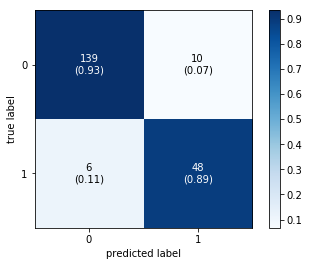


The figure below illustates the best perfoming classifier from the Binary Classifications



The table below compares other Binary Classifications using the same QoS features, i.e. ('packets_per_flow_mean', 'AB_bytes_per_flow_mean', 'BA_bytes_per_flow_mean', 'BA_packets_per_flow_mean', 'RTT_mean')




Multiclass Classifications

The table below shows the first 20 highest scoring Multiclass Classifications


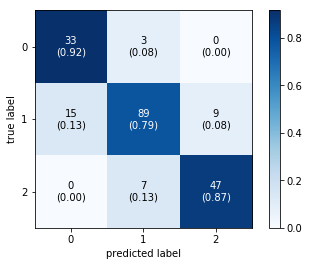


The figure below illustates the best perfoming classifier from the Multiclass Classifications



The table below compares other Multiclass Classifications using the same QoS features, i.e. ('flow_duration_mean', 'bytes_per_flow_mean', 'packets_per_flow_mean', 'AB_bytes_per_flow_mean', 'BA_bytes_per_flow_mean', 'BA_packets_per_flow_mean')


In [207]:
#with warnings.catch_warnings():
# ignore all caught warnings
#  warnings.filterwarnings("ignore")
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)    
import itertools as it
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
classifiers = [LogisticRegression(),
               DecisionTreeClassifier(max_depth=5),
               KNeighborsClassifier(3),
               LinearDiscriminantAnalysis(),
               RandomForestClassifier(max_depth=5,n_estimators=3, random_state=0),
               GaussianNB(),
               SVC(probability=True),
               #MLPClassifier(),
               #GaussianProcessClassifier(1.0 * RBF(1.0)),
               AdaBoostClassifier(),
               QuadraticDiscriminantAnalysis()]
#classifiers = [LogisticRegression(),DecisionTreeClassifier(max_depth=5),KNeighborsClassifier(3),
#               RandomForestClassifier(max_depth=5,n_estimators=3, random_state=0),
#               GaussianNB(),SVC(),MLPClassifier()]
#classifiers = [RandomForestClassifier(max_depth=5,n_estimators=3, random_state=0)]
classifications=[
    {
        'desc':"Binary Classifications",
        'bins':[0,indexNoStressHigh,np.inf],
        'names':[0,1],
#        'names':["good","bad"],
        'low': indexNoStressHigh,
        'high':indexNoStressHigh
    },
    {
        'desc':"Multiclass Classifications",
        'bins':[0,indexNoStressLow,indexNoStressHigh,np.inf],
        'names': [0,1,2], 
#        'names':["good","acceptable","bad"],        
        'low': indexNoStressLow,
        'high':indexNoStressHigh

        
    }
]
_features = pd.DataFrame()    
_features['flow_duration_mean'] = dfSkydiveFlowsLabeledAgg['flow_duration']['mean']
_features['bytes_per_flow_mean'] = dfSkydiveFlowsBytesPerFlowLabeledAgg['bytes_per_flow']['mean'] 
_features['packets_per_flow_mean'] = dfSkydiveFlowsPacketsPerFlowLabeledAgg['packets_per_flow']['mean'] 
_features['AB_bytes_per_flow_mean'] = dfSkydiveFlowsABBytesPerFlowLabeledAgg['AB_bytes_per_flow']['mean'] 
_features['BA_bytes_per_flow_mean'] = dfSkydiveFlowsBABytesPerFlowLabeledAgg['BA_bytes_per_flow']['mean'] 
_features['AB_packets_per_flow_mean'] = dfSkydiveFlowsABPacketsPerFlowLabeledAgg['AB_packets_per_flow']['mean'] 
_features['BA_packets_per_flow_mean'] = dfSkydiveFlowsBAPacketsPerFlowLabeledAgg['BA_packets_per_flow']['mean']
_features['RTT_mean'] = dfSkydiveFlowsRTTLabeledAgg['Metric.RTT']['mean']

_test_features = pd.DataFrame()    
_test_features['flow_duration_mean'] = dfSkydiveFlowsLabeledAggTest['flow_duration']['mean']
_test_features['bytes_per_flow_mean'] = dfSkydiveFlowsBytesPerFlowLabeledAggTest['bytes_per_flow']['mean'] 
_test_features['packets_per_flow_mean'] = dfSkydiveFlowsPacketsPerFlowLabeledAggTest['packets_per_flow']['mean'] 
_test_features['AB_bytes_per_flow_mean'] = dfSkydiveFlowsABBytesPerFlowLabeledAggTest['AB_bytes_per_flow']['mean'] 
_test_features['BA_bytes_per_flow_mean'] = dfSkydiveFlowsBABytesPerFlowLabeledAggTest['BA_bytes_per_flow']['mean'] 
_test_features['AB_packets_per_flow_mean'] = dfSkydiveFlowsABPacketsPerFlowLabeledAggTest['AB_packets_per_flow']['mean'] 
_test_features['BA_packets_per_flow_mean'] = dfSkydiveFlowsBAPacketsPerFlowLabeledAggTest['BA_packets_per_flow']['mean']
_test_features['RTT_mean'] = dfSkydiveFlowsRTTLabeledAgg['Metric.RTT']['mean']


#print("Do ML Classification")
#print("training set size",_features.shape[0])
#print("testing set size",_test_features.shape[0])
print("Examine all combinations of the features listed below:")
for f in list(_features.columns):
    print("      ",f)
print("Estimate QoE from QoS feature combinations using the classifiers listed below:")
for clf in classifiers:
    print("      ",str(clf)[0:str(clf).index('(')])
print("Estimate QoE from QoS feature combinations (descibed above) using the classifiers listed below:")
for classification in classifications:
    print("")
    print("")
    print("{}".format(classification["desc"]))    
    dfCombinationScores = pd.DataFrame(columns = ['Features','Classifier','f1_score','accuracy_score','log_loss_score'])
    #dfCombinationScores = pd.DataFrame()
    bestClassifiers = []
    qoeTables=[]
    bins = classification['bins']
    names = classification['names']
    targets = pd.cut(dfIndex['elapse_time'], bins,labels=names)
    test_targets = pd.cut( dfIndexTest['elapse_time'], bins,labels=names)
    for i in range(1,_features.shape[1]+1):
    #okfor i in range(1,2):
        for comb in it.combinations(list(_features.columns),i):
            #print(comb)
            features = pd.DataFrame()
            test_features = pd.DataFrame()
            for f in comb:
                features[f] = _features[f]
                test_features[f] = _test_features[f]
            X_train, X_test, y_train, y_test = train_test_split(features,targets, test_size=0.0, random_state=0)
            bestClassifier, qoeTable = QoEEstimator(classifiers,X_train, y_train,test_features,test_targets)
            bestClassifiers.append(bestClassifier.copy())
            qoeTables.append(qoeTable)
            dfCombinationScores = dfCombinationScores.append({
                'Features' : str(comb).replace(",","<br>"),
                'Classifier' : bestClassifier["classifier"], 
                'f1_score' :  bestClassifier["f1_score"],
                'accuracy_score' :  bestClassifier["accuracy_score"],
                #"roc_auc_score" : bestClassifier["roc_auc_score"],
                "log_loss_score" : bestClassifier["log_loss_score"]
            },ignore_index=True)
            
#    dfCombinationScores = dfCombinationScores.sort_values(by=['f1_score','accuracy_score'], ascending=False)
    dfCombinationScores = dfCombinationScores.sort_values(
#      by=['f1_score','accuracy_score',"roc_auc_score",'log_loss_score'], ascending=[False,False,False,True]).round(3).reset_index()
       by=['f1_score','accuracy_score','log_loss_score'], ascending=[False,False,True]).round(3)

    bestIndex = dfCombinationScores.index[0]
    bestClassifier = bestClassifiers[bestIndex]
    bestFeatures = dfCombinationScores.Features[bestIndex]
    qoeTable = qoeTables[bestIndex]
    
    table = ff.create_table(dfCombinationScores.head(20),height_constant=100)
    print("")
    print("The table below shows the first 20 highest scoring {}".format(classification["desc"]))
    iplot(table)
    
    print("")
    cfm = confusion_matrix(bestClassifier["y_test"],bestClassifier["y_pred"])
    fig, ax = plot_confusion_matrix(conf_mat=cfm,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
    plt.show()                      

    print("")
    print("The figure below illustates the best perfoming classifier from the {}".format(classification["desc"]))
    title = "QoE from QoS Actual vs Prediction<br> QoE Target: workload duration, QoS features: {} <br>classifier: {}, f1_score: {}, accuracy: {}".format(bestFeatures.replace("<br>",","),bestClassifier["classifier"],str(round(bestClassifier["f1_score"],2)),str(round(bestClassifier["accuracy_score"],2)))
    #plotModelEstimates(bestClassifier["y_test"],bestClassifier["y_pred"],'testing samples','QoE Classifications<br>0 is good  1 is bad',title,names)
    if classification["desc"] == "Binary Classifications":
        title = "QoE from QoS Actual vs Prediction (Binary Classifications)<br> QoE Target: workload duration, QoS features: {} <br>classifier: {}, f1_score: {}, accuracy: {}".format(bestFeatures.replace("<br>",","),bestClassifier["classifier"],str(round(bestClassifier["f1_score"],2)),str(round(bestClassifier["accuracy_score"],2)))

        plotModelEstimates(bestClassifier["y_test"],bestClassifier["y_pred"],'testing samples','QoE Classifications<br>good             bad',title,names)
        plotWithBoundariesAndEstimations(
            dfIndexTest,'stress_test','elapse_time',
            'testing samples','benchmark duration (ms)',
            'Testing Set Benchmark Duration (QoE)<br> benchmark: wp4<br>Single threshold boundary for Binary Classification',
            indexNoStressHigh,indexNoStressHigh,
            bestClassifier["y_test"],bestClassifier["y_pred"]
        )
    elif classification["desc"] == "Multiclass Classifications":
        title = "QoE from QoS Actual vs Prediction (Multiclass Classifications)<br> QoE Target: workload duration, QoS features: {} <br>classifier: {}, f1_score: {}, accuracy: {}".format(bestFeatures.replace("<br>",","),bestClassifier["classifier"],str(round(bestClassifier["f1_score"],2)),str(round(bestClassifier["accuracy_score"],2)))
        plotModelEstimates(bestClassifier["y_test"],bestClassifier["y_pred"],'testing samples','QoE Classifications<br>good acceptable bad',title,names)
        plotWithBoundariesAndEstimations(
            dfIndexTest,'stress_test','elapse_time',
            'testing samples',
            'benchmark duration (ms)','Testing Set Benchmark Duration (QoE)<br> benchmark: wp4<br>Multiple threshold boundaries for Multiclass Classification',
            indexNoStressLow,indexNoStressHigh,
            bestClassifier["y_test"],bestClassifier["y_pred"]
        )
    print("")
    print("The table below compares other {} using the same QoS features, i.e. {}".format(classification["desc"],bestFeatures.replace("<br>",",")))          
    iplot(qoeTable)
    
          


    
    
        
        
    


## Workload Duration evaluation complete!
The rest is experimentation with the data, i.e. under construction.

## Skydive data evaluation

In [173]:
print(dfIndex.groupby(['stress_test']).agg({'elapse_time': ['min','max','median','mean']}).dropna())
print(dfSkydiveFlowsLabeled.groupby(['stress_test']).agg({'flow_duration': ['min','max','median','mean']}).dropna())
#print(dfJmeterLabeled.groupby(['stress_test','transaction']).agg({'avg': ['min','max','median','mean']}).dropna())


                   elapse_time                               
                           min     max  median           mean
stress_test                                                  
 no_stress              145493  241331  159268  162344.367188
iperf-d-1xP50           148663  233657  198010  191828.823529
iperf-d-1xP60           144038  243928  204740  194727.611940
iperf-d-2xP50           146536  239400  197956  191388.803030
iperf-d-2xP60           146026  239998  214726  198770.569231
iperf-d-3xP50           154777  267883  225583  217471.104478
iperf-d-3xP60           150619  296665  251778  235417.923077
iperf-d-5xP60           226543  300600  262308  261396.816667
iperf-d-5xP60-b10G      241120  281917  263454  261831.733333
                   flow_duration                              
                             min    max   median          mean
stress_test                                                   
iperf-d-1xP50                844  55223  13051.0  15743.574449
iper

In [174]:
#print(dfSkydiveFlowsLabeled.count())
#print(dfSkydiveFlowsLabeled['_source.LastUpdateMetric.ABBytes'].unique())
#print(dfSkydiveFlowsLabeled['_source.LastUpdateMetric.BABytes'].unique())
#todo have to merge these for flowduration
print("examine uuid to see if it is unique")
print(dfSkydiveFlowsLabeled.shape)
vc = dfSkydiveFlowsLabeled["UUID"].value_counts()
#print(dfSkydiveFlowsLabeled.count())
print( vc[vc > 1])
#df_temp = dfSkydiveFlowsLabeled[dfSkydiveFlowsLabeled["_source.UUID"].value_counts() > 1]
df_temp = dfSkydiveFlowsLabeled[dfSkydiveFlowsLabeled.duplicated()]
print(df_temp.shape)
print(df_temp.head(20))                                                                            
#print(list(df_temp.index))
df_temp = dfSkydiveFlowsLabeled[dfSkydiveFlowsLabeled["UUID"].isin(df_temp.index)]
#df_temp = dfSkydiveFlowsLabeled[dfSkydiveFlowsLabeled["_source.UUID"].value_counts() > 1]
print(df_temp.shape)
print(df_temp[["UUID",'Metric.Start','Metric.Last','flow_duration']].sort_values(by=["UUID"]).head(20))

#dfSkydiveFlowsLabeled[dfSkydiveFlowsLabeled["_source.UUID"] == 'd0ce31611f3d1317' ]
#print(dfSkydiveFlowsLabeled[["_source.UUID",'_source.Metric.Start','_source.Metric.Last','flow_duration']].sort_values(by=["_source.UUID"]))
#print(dfSkydiveFlowsLabeled[dfSkydiveFlowsLabeled["_source.UUID"] == 'd0ce31611f3d1317' ][["_source.UUID",'_source.Metric.Start','_source.Metric.Last','flow_duration']])
#print(dfSkydiveFlowsLabeled[[dfSkydiveFlowsLabeled["_source.UUID"] == 'd0ce31611f3d1317' ]["_source.UUID",'_source.Metric.Start','_source.Metric.Last','flow_duration']])

examine uuid to see if it is unique
(9845, 50)
Series([], Name: UUID, dtype: int64)
(0, 50)
Empty DataFrame
Columns: [Application, IPMetric.FragmentErrors, IPMetric.Fragments, L3TrackingID, Last, LastUpdateMetric.ABBytes, LastUpdateMetric.ABPackets, LastUpdateMetric.BABytes, LastUpdateMetric.BAPackets, LastUpdateMetric.Last, LastUpdateMetric.RTT, LastUpdateMetric.Start, LayersPath, Link.A, Link.B, Link.ID, Link.Protocol, Metric.ABBytes, Metric.ABPackets, Metric.BABytes, Metric.BAPackets, Metric.Last, Metric.RTT, Metric.Start, Network.A, Network.B, Network.ID, Network.Protocol, NodeTID, ParentUUID, RawPacketsCaptured, Start, TrackingID, Transport.A, Transport.B, Transport.ID, Transport.Protocol, UUID, Unnamed: 0, Unnamed: 0.1, begin, stress_test, workload, flow_duration, bytes_per_flow, AB_bytes_per_flow, BA_bytes_per_flow, packets_per_flow, AB_packets_per_flow, BA_packets_per_flow]
Index: []

[0 rows x 50 columns]
(0, 50)
Empty DataFrame
Columns: [UUID, Metric.Start, Metric.Last, flow_

In [175]:
#dfSkydiveFlowsLabeledAgg = dfSkydiveFlowsLabeled.groupby(['begin','stress_test']).agg({'flow_duration': ['min','max','median','mean','std']}).dropna().reset_index()

plot4Ms(dfSkydiveFlowsLabeledAgg,'begin','flow_duration','training samples','flow duration (ms)','HTTP Non-Persistent Connection <br> Wordpress Flow Duration (QoS)')
#print(dfSkydiveFlowsLabeledAgg)
#dfSkydiveFlowsLabeledAgg['flow_duration']['median'].plot(kind='line',title='median flow duration (QoS)')

In [176]:

plot4Ms(dfSkydiveFlowsRTTLabeledAggTest,'begin','Metric.RTT','testing samples','RTT','HTTP Non-Persistent Connection <br> Wordpress Flow Duration (QoS)')

## Jmeter data evaluation

In [177]:
print(dfJmeterLabeled.groupby(['stress_test','transaction']).agg({'avg': ['min','max','median','mean']}).dropna())

                                  avg                              
                                  min    max   median          mean
stress_test        transaction                                     
 no_stress         get_15MB     12191  33867  20416.0  20742.623566
                   get_5MB       4320  13011   6447.0   6526.697595
iperf-d-1xP50      get_15MB     13135  33160  22419.0  22842.674064
                   get_5MB       4323  16125   8066.0   8119.060547
iperf-d-1xP60      get_15MB     13077  33773  22395.0  22981.775887
                   get_5MB       4348  14787   7819.0   7862.867530
iperf-d-2xP50      get_15MB     12234  33651  21284.0  21913.059406
                   get_5MB       4323  15547   8171.0   8187.017154
iperf-d-2xP60      get_15MB     13141  33277  22323.0  22433.738881
                   get_5MB       4323  14684   8623.0   8518.927565
iperf-d-3xP50      get_15MB     12514  32935  21199.0  21726.380319
                   get_5MB       4323  19996   9

In [178]:
plot4Ms(dfJmeterLabeledAgg,'begin','avg','training samples','response time (ms)','HTTP Non-Persistent Connection <br> Wordpress Response Time (QoE)')

In [179]:

dfJmeterLabeledAgg = dfJmeterLabeled.groupby(['begin','transaction']).agg({'avg': ['min','max','median','mean','std']}).dropna().reset_index()
dfJmeterLabeledStressAgg = dfJmeterLabeled.groupby(['transaction','stress_test']).agg({'avg': ['min','max','median','mean','std']}).dropna().reset_index()
print(dfJmeterLabeledStressAgg.head())

for t in dfJmeterLabeledStressAgg.transaction.unique():
    print(t)
    df = dfJmeterLabeledStressAgg[(dfJmeterLabeledStressAgg["transaction"] == t) & (dfJmeterLabeledStressAgg["stress_test"] == " no_stress")]
    low = round(max(df['avg']['max']))
    high = round(max(df['avg']['max']+df['avg']['std']*4))
    print(low)
    print(high)
    df = dfJmeterLabeledStressAgg[(dfJmeterLabeledStressAgg["transaction"] == t)]
    plot4MsWithThreshholds(df,'stress_test','avg','training stress configurations','avg request duration (ms)','Avg REST request Duration (QoE)<br> workload: wp4<br>Single threshold for Binary Classification',high,high)
    plot4MsWithThreshholds(df,'stress_test','avg','training stress configurations','avg request duration (ms)','Avg REST request Duration (QoE)<br> workload: wp4<br>Multiple thresholds for Multiclass Classification',low,high)

  transaction    stress_test    avg                                           
                                min    max   median          mean          std
0    get_15MB      no_stress  12191  33867  20416.0  20742.623566  3614.105977
1    get_15MB  iperf-d-1xP50  13135  33160  22419.0  22842.674064  4345.593231
2    get_15MB  iperf-d-1xP60  13077  33773  22395.0  22981.775887  4409.955153
3    get_15MB  iperf-d-2xP50  12234  33651  21284.0  21913.059406  4538.555932
4    get_15MB  iperf-d-2xP60  13141  33277  22323.0  22433.738881  4040.207628
get_15MB
33867
48323


get_5MB
13011
18599


In [180]:

plot4Ms(dfJmeterLabeledAggTest,'begin','avg','testing samples','service completion time (ms)','Measured QoE (service completion time)')

In [181]:

plot4Ms(dfSkydiveFlowsLabeledAggTest,'begin','flow_duration','testing samples','flow duration (ms)','Measured QoS (flow duration)')

In [182]:
dfJmeterLabeledAgg1 = dfJmeterLabeled.groupby(['stress_test']).agg({'avg': ['min','max','median','mean','std']}).dropna()
print(dfJmeterLabeledAgg1)
#dfJmeterLabeledAgg1['avg']['median'].plot(kind='line',title='median avg resonse time (QoE)')

                     avg                                           
                     min    max   median          mean          std
stress_test                                                        
 no_stress          4320  33867   8288.0  12948.305228  7552.625448
iperf-d-1xP50       4323  33160  10060.0  14202.570774  7929.259160
iperf-d-1xP60       4348  33773   9857.0  14099.748976  8104.214032
iperf-d-2xP50       4323  33651  10374.0  13902.159600  7530.656406
iperf-d-2xP60       4323  33277  10639.0  14254.364281  7501.517853
iperf-d-3xP50       4323  32935  12036.5  14449.530384  6826.187036
iperf-d-3xP60       4321  33668  13877.0  15444.340144  6748.263855
iperf-d-5xP60       4373  33483  14799.0  17486.687170  6398.605127
iperf-d-5xP60-b10G  7985  32663  15104.5  17831.325342  5944.110785


In [183]:
#plotAgg2(dfJmeterLabeledAgg1.reset_index(),dfSkydiveFlowsLabeledAgg1.reset_index(),'avg','median','flow_duration','median','begin','median avg response time','median flow duration (QoS)','begin','millisecond','median avg response time (QoE) and flow duration (Qos)' )

## correlation on aggregations of avg response time (QoE) and flow duration (Qos) (merge based on begin time for multiple samples)

In [184]:
df1 = dfJmeterLabeledAgg
df2 = dfSkydiveFlowsLabeledAgg
#df1 = df1[['time','avg']]
#df2 = df2[['_source.Metric.Last','flow_duration']]
dfMerged = pd.merge(df1,df2,left_on='begin',right_on='begin').dropna()
#df = df[df['flow_duration'] != 0]
#print(df.head())
#print(df.count())
#print(df['avg']['median'].corr(df['flow_duration']['median'],method='spearman'))
print("median correlation",dfMerged['avg']['median'].corr(dfMerged['flow_duration']['median'],method='pearson'))
print("mean correlation",dfMerged['avg']['mean'].corr(dfMerged['flow_duration']['mean'],method='pearson'))
print("min correlation",dfMerged['avg']['min'].corr(dfMerged['flow_duration']['min'],method='pearson'))
print("max correlation",dfMerged['avg']['max'].corr(dfMerged['flow_duration']['max'],method='pearson'))
print("std correlation",dfMerged['avg']['std'].corr(dfMerged['flow_duration']['std'],method='pearson'))

median correlation 0.26768803479642367
mean correlation 0.32168908059323575
min correlation 0.19739909892781707
max correlation 0.20795000170573463
std correlation 0.08843582853263958


/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/generic.py:3947: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



In [185]:
#print(dfSkydiveFlowsRTTLabeledAgg.head(10))
#columns = ['_source.Metric.RTT']
#dfRTT = dfSkydiveFlowsRTTLabeledAgg['_source.Metric.RTT'].drop(columns,axis=1)
#print(dfRTT)


## Debugging data
* 

In [186]:
#for b in dfJmeterLabeled.begin.unique():
#    stress = dfIndex[dfIndex.begin == b].stress_test
#    plotJmeter(dfJmeterLabeled[dfJmeterLabeled.begin == b],"wordpress response time (QoE) sample "+str(b)+" ("+stress+")")
#    plotSkydiveFlows(dfSkydiveFlowsLabeled[dfSkydiveFlowsLabeled.begin == b],"wordpress flow duration (QoS) sample "+str(b)+" ("+stress+")","flow_duration","flow duration (ms)")

   